In [1]:
#importing libareris
import pandas as pd
import numpy as np
import os
#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For Transforming our target vatiable
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#For preprocessing text data
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Injection

In [5]:
path1='Data/bugs.txt'
print(path1)
path2='Data/comments.txt'
print(path2)
path3='Data/complaints.txt'
print(path3)
path4='Data/meaningless.txt'
print(path4)
path5='Data/requests.txt'
print(path5)


Data/bugs.txt
Data/comments.txt
Data/complaints.txt
Data/meaningless.txt
Data/requests.txt


In [6]:
def text_data(path):
    text_Body=[]
    with open(path, "r", encoding='windows-1256') as f:
        lines = f.readlines()
            #print(lines) 
        text_Body.append(lines)
    text_body_appended=[]
    for i in range(0,len(text_Body[0])):
        value=text_Body[0][i]
        text_body_appended.append(value)
    return text_body_appended

In [7]:
bugs=text_data(path1)
comments=text_data(path2)
complaints=text_data(path3)
meaningless=text_data(path4)
requests=text_data(path5)

## Data Visualisation

In [8]:
print(len(bugs))
print(len(comments))
print(len(complaints))
print(len(meaningless))
print(len(requests))

72
1759
950
306
103


In [9]:
def data_frame(txt,category):
    column_names=('text','Category')
    df = pd.DataFrame(columns=column_names)
    df['text']=txt
    df['Category']=category
    return df

In [10]:
data=data_frame(bugs,"Bug")
data=data.append(data_frame(comments,"comments"))
data=data.append(data_frame(complaints,"complaints"))
data=data.append(data_frame(meaningless,"meaningless"))
data=data.append(data_frame(requests,"requests"))

In [11]:
data['Category'].unique()

array(['Bug', 'comments', 'complaints', 'meaningless', 'requests'],
      dtype=object)

In [12]:
data.head()

,text,Category
0,A lot of the time my purchase won't show up.\n,Bug
1,I only see the notification if I catch it live...,Bug
2,When I type the typing area should slide above...,Bug
3,"I ran it, and promptly got driver problems wit...",Bug
4,Still calls keep dropping with the new updates\n,Bug


In [13]:
data.groupby(['Category']).size()

Category
Bug              72
comments       1759
complaints      950
meaningless     306
requests        103
dtype: int64

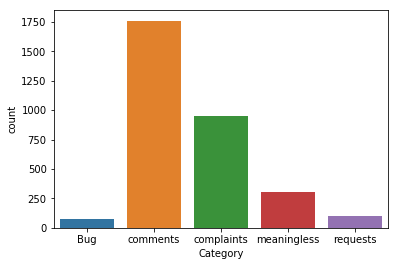

In [14]:
sns.countplot(x='Category',data=data,order=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
plt.show()

## Data Cleaning and Preparation

In [15]:
#remove link starts with https
data['text'] = data['text'].map(lambda x:re.sub('http.*','',str(x)))
#removing data and time (numeric values)
data['text'] = data['text'].map(lambda x:re.sub('[0-9]','',str(x)))
#removing \n
data['text'] = data['text'].map(lambda x:re.sub('[\\n]','',str(x)))
#removing some special characters
data['text'] = data['text'].map(lambda x:re.sub('[#|*|$|:|\\|&]','',str(x)))


In [16]:
my_stopwords = ['jan','january','february' 'feb', 'march', 'april', 'may', 'june','july','aug',
                    'october','October','june','july','February','apr','Apr','february','jun','jul','feb','sep',
                    'august','sept','september','oct','october','nov','november','dec','december','mar','november october','wasnt']

In [17]:
#preparing train data
#removing stopwords and tokenizing it.
stop=stopwords.words('english')
text=[]
none=data['text'].map(lambda x:text.append(' '.join
       ([word for word in str(x).strip().split() if not word in set(stop) and word not in my_stopwords])))
tfid=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None)
x_features=tfid.fit_transform(text).toarray()
x_features=pd.DataFrame(x_features)

## Training

In [18]:
#preparing target variable
target=data['Category']
label=LabelEncoder()
target=label.fit_transform(target)
target=to_categorical(target)

In [19]:
target=pd.DataFrame(data=target,columns=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
target.head()

,Bug,comments,complaints,meaningless,requests
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [21]:
#training with One Vs All(One VS Rest)
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression as lg
logistic=lg(penalty='l2',solver='liblinear',C=5,multi_class='ovr',max_iter=5000)#l2 means ridge regression in which the coefficient is squared
#newton cg is used with l2 regression fo roptimization

**Training Bugs vs all**

In [22]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[:144,:],y=target.iloc[:144,0],cv=5)
acc.mean()

0.8200000000000001

**Training comments vs all**

In [23]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[100:2100,:],y=target.iloc[100:2100,1],cv=5)
acc.mean()

0.8645083969274807

**Training  complaints vs all**

In [24]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[1500:3500,:],y=target.iloc[1500:3500,2],cv=5)
acc.mean()

0.6124260355029586

**Training meaningless vs all**

In [25]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[2700:3300,:],y=target.iloc[2700:3300,3],cv=5)
acc.mean()

0.6941155718769857

**Training requests vs all**

In [26]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[-206:,:],y=target.iloc[-206:,4],cv=5)
acc.mean()

0.7230952380952381

## Artificial Neural Network

In [27]:
#lets dig deeper and apply Deep learning for better accuracy
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import regularizers
from keras.layers import Dropout

In [28]:
x_features.shape

(3190, 5193)

### Preparing target variable for ANN

In [29]:
#preparing target variable
target=data['Category']
label=LabelEncoder()
target=label.fit_transform(target)
target=to_categorical(target)

In [30]:
target=pd.DataFrame(data=target,columns=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
target.head()

,Bug,comments,complaints,meaningless,requests
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [31]:
clf=Sequential()
#adding layers to ANN
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001),input_dim=5193))
clf.add(Dropout(0.2))
#adding two more hidden layer to ANN
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001)))
clf.add(Dropout(0.2))
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001)))
clf.add(Dropout(0.2))
#adding output layer
clf.add(Dense(units=5,activation="softmax",kernel_initializer="uniform"))
#compiling ANN
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
#fitting ANN
hist=clf.fit(x_features,target,batch_size=32,epochs=24)

Epoch 1/24
3190/3190 [==============================] - 50s 16ms/step - loss: 4.2502 - acc: 0.5793
Epoch 2/24
3190/3190 [==============================] - 47s 15ms/step - loss: 1.1124 - acc: 0.7197
Epoch 3/24
3190/3190 [==============================] - 49s 16ms/step - loss: 0.9173 - acc: 0.8031
Epoch 4/24
3190/3190 [==============================] - 51s 16ms/step - loss: 0.8109 - acc: 0.8376
Epoch 5/24
3190/3190 [==============================] - 53s 17ms/step - loss: 0.7222 - acc: 0.8558
Epoch 6/24
3190/3190 [==============================] - 50s 16ms/step - loss: 0.6674 - acc: 0.8762
Epoch 7/24
3190/3190 [==============================] - 51s 16ms/step - loss: 0.6128 - acc: 0.8868
Epoch 8/24
3190/3190 [==============================] - 52s 16ms/step - loss: 0.5698 - acc: 0.8981
Epoch 9/24
3190/3190 [==============================] - 48s 15ms/step - loss: 0.5271 - acc: 0.9044
Epoch 10/24
3190/3190 [==============================] - 47s 15ms/step - loss: 0.4946 - acc: 0.9172
Epoch 11/

## Evaluation by Graph

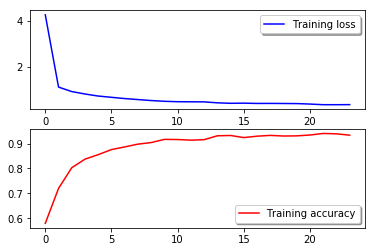

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['acc'], color='r', label="Training accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Prediction

In [119]:
test=['There should be a Free Demo Mode :/\n',
      'When I type the typing area should slide above my keyboard but it doesnt.',
      'A lot of the time my purchase wont show up.',
      "App constantly crashes and looks like it was designed in 2009... Have to open the app multiple times before I get to a login screen, usually receiving a 'not responding' error.\n"]

In [120]:
def cleaner(a):
    test=pd.DataFrame(a,columns=['text'])
    #remove link starts with https
    test['text'] = test['text'].map(lambda x:re.sub('http.*','',str(x)))
    #removing data and time (numeric values)
    test['text'] = test['text'].map(lambda x:re.sub('[0-9]','',str(x)))
    #removing some special characters
    test['text'] = test['text'].map(lambda x:re.sub('[#|*|$|:|\\|&]','',str(x)))
    
    return test

In [121]:
b=cleaner(test)

In [122]:
stop=stopwords.words('english')
text=[]
none=b['text'].map(lambda x:text.append(' '.join
    ([word for word in str(x).strip().split() if not word in set(stop)])))
x_features_test=tfid.transform(text).toarray()
x_features_test=pd.DataFrame(x_features_test)

**Predicting by ANN model**

In [123]:
results=clf.predict(x_features_test)

In [124]:
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results

array([4, 0, 2, 2], dtype=int64)

**All predictions are correct**

In [127]:
results=pd.DataFrame(results,columns=['Category'])
int_category={0:'bug', 1:'comments', 2:'complaints', 3:'meaningless', 4:'requests'}
results['Category']=results['Category'].apply(lambda x:int_category[x])
results

,Category
0,requests
1,bug
2,complaints
3,complaints


## Saving model

In [129]:
clf.save('feedclassifier.h5')